# Vision
This is a dev file for the vision module

### 1- Importing necessary librairies

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Vision.CamCalib as cb
import Vision.EnvTracker as tracker
import importlib
importlib.reload(cb)
importlib.reload(tracker)
import matplotlib.colors as colors
import math

### 2- Camera Calibration (Removing distortions)
Based on this OpenCV [tutorial](https://docs.opencv.org/4.x/da/d13/tutorial_aruco_calibration.html) 

i. Using the CamCalib object, take some pictures with the chessboard pattern if not already done

In [9]:
cam_stream = cv2.VideoCapture(0)
cam_stream.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cam_stream.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

calib = cb.CamCalib(cam_stream, (9,6))
calib.take_pictures()

cam_stream.release()

In [211]:
tag = cv2.aruco.generateImageMarker(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50), 6, 100)
cv2.imwrite('ArucoTags/m6.png', tag)

True

ii. Use the calibrate function to extract camera parameters and save them in a numpy .npz file to load them later

(-0.5, 999.5, 699.5, -0.5)

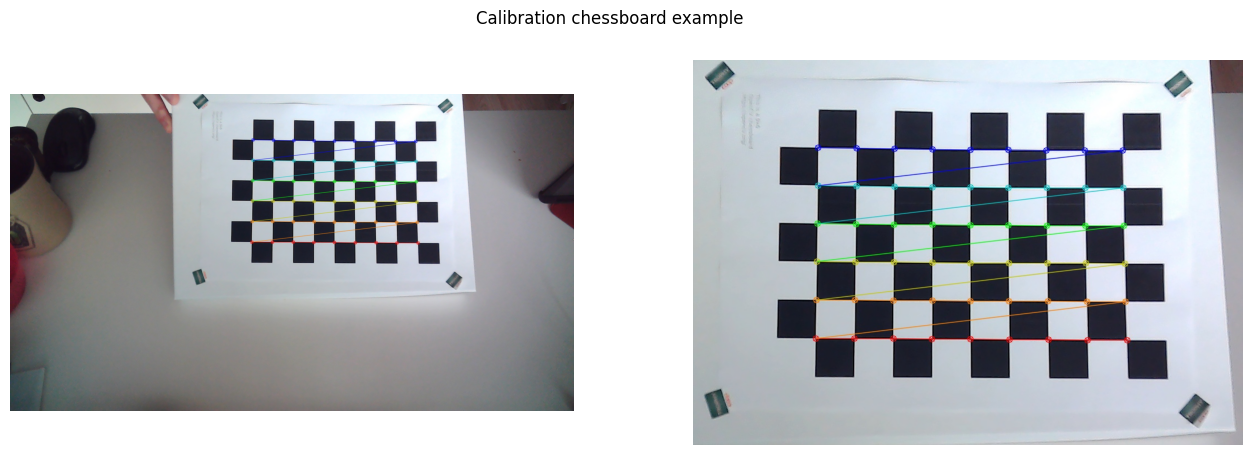

In [327]:
calib = cb.CamCalib(None, (9,6))
#calib.calibrate(25)

# Show example
fig, ax = plt.subplots(1,2)
fig.suptitle('Calibration chessboard example')
fig.set_size_inches(16,5)
im1 = cv2.imread('Vision/images/cal/marked_4.jpg')
ax[0].imshow(im1[:,:,::-1])
ax[0].axis('off')
ax[1].imshow(im1[:700,600:1600,::-1])
ax[1].axis('off')


As one can see, OpenCV detects intersection between black squares. Knowing the size of each square (here 25 mm), it can deduce a mapping from object points to image points. Thus, having multiple viewpoints create a set of equations taht are used to find the parameters that minimizes the re-projection error. This calibration is crucial to straighten the lines of the image and to retrieve camera matrix and distorsions parameters. Knowing all of that allows to estimate accurately distances of objects in image!

iv. Apply the correction to the image

(37, 16, 1860, 1035)


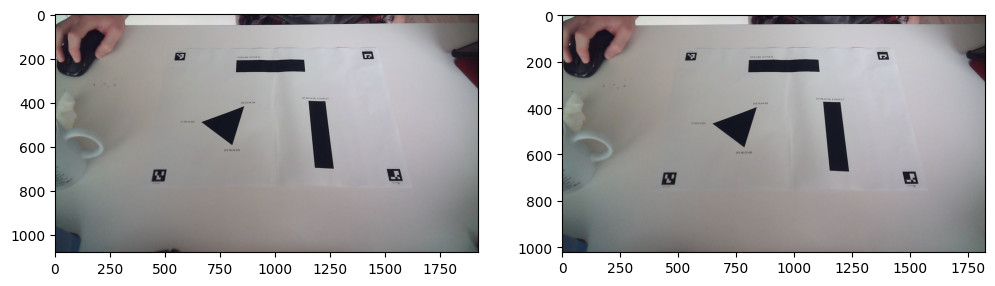

In [328]:
MAP_FILE = "Vision/images/TEST_MAP.jpg"
# Load parameters
cam_mat, dist_coefs, rvecs, tvecs = calib.load_camera_params()

test_img = cv2.imread(MAP_FILE)
# Get optimal camera matrix to keep img dimension the same
h, w = test_img.shape[:2]
new_cam_mat, roi = cv2.getOptimalNewCameraMatrix(cam_mat, dist_coefs, (w,h), 1, (w,h), 0)
print(roi)
x,y,w,h = roi

# Using remapping
mapx, mapy = cv2.initUndistortRectifyMap(cam_mat, dist_coefs, None, new_cam_mat, (w,h), 5)
test_img_corr = cv2.remap(test_img, mapx, mapy, cv2.INTER_LINEAR)
#cv2.line(test_img_corr, (750+x,0), (750+x,1080), [255,0,0], 2)
#cv2.line(test_img, (750,0), (750,1080), [255,0,0], 2)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,4)
axs[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

#test_img_corr = cv2.undistort(test_img, cam_mat, dist_coefs, None, new_cam_mat)
axs[1].imshow(test_img_corr[y:y+h,x:x+w,::-1])


### 3- Marker pose detection
i. Prepare environment (load calib data)

In [329]:
calib = cb.CamCalib(None, (9,6))
cam_mat, dist_coefs, rvecs, tvecs = calib.load_camera_params()
new_cam_mat, roi = cv2.getOptimalNewCameraMatrix(cam_mat, dist_coefs, (1920,1080), 1, (1920,1080), 0)

ii. Identify aruco markers in camera feed

[[11.34010735]
 [ 4.16778369]
 [30.79894045]]
[[11.3421178]
 [-8.1867326]
 [39.0778301]]
[[-9.82780332]
 [ 4.24511205]
 [30.69438822]]
[[-10.0518226 ]
 [ -8.09497653]
 [ 39.0224592 ]]


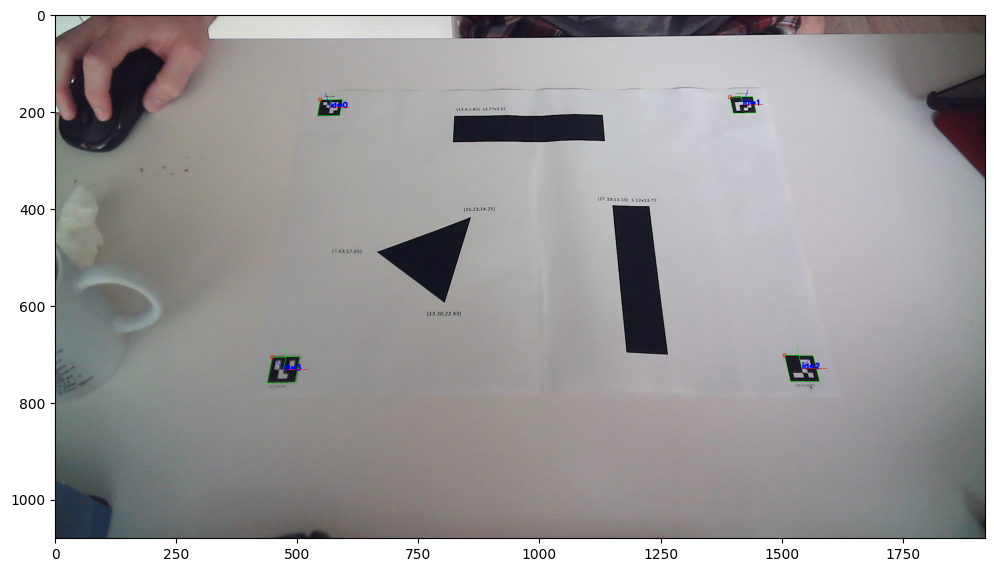

In [330]:
ORIGIN_ID = 1
MARKER_SIZE = 1.15
detector = cv2.aruco.ArucoDetector(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50))
img_dectect = cv2.copyTo(test_img, None)
corners, ids, rejected = detector.detectMarkers(img_dectect)
img_detection = cv2.aruco.drawDetectedMarkers(img_dectect, corners, ids)
# Create corner points
obj_points = cv2.Mat(np.array([[-MARKER_SIZE/2, MARKER_SIZE/2, 0], 
                        [MARKER_SIZE/2, MARKER_SIZE/2, 0], 
                        [MARKER_SIZE/2, -MARKER_SIZE/2, 0], 
                        [-MARKER_SIZE/2, -MARKER_SIZE/2, 0]]))


for c in corners:
    ret, rvec, tvec = cv2.solvePnP(obj_points, c, cam_mat, dist_coefs)
    print(tvec)
    img_detection = cv2.drawFrameAxes(img_detection, cam_mat, dist_coefs, rvec, tvec, 1, 1)


fig = plt.figure(figsize=(12,8))
plt.imshow(img_detection[:,:,::-1])

ii. Find position and orientation of markers

[ 465  178 1107  566]


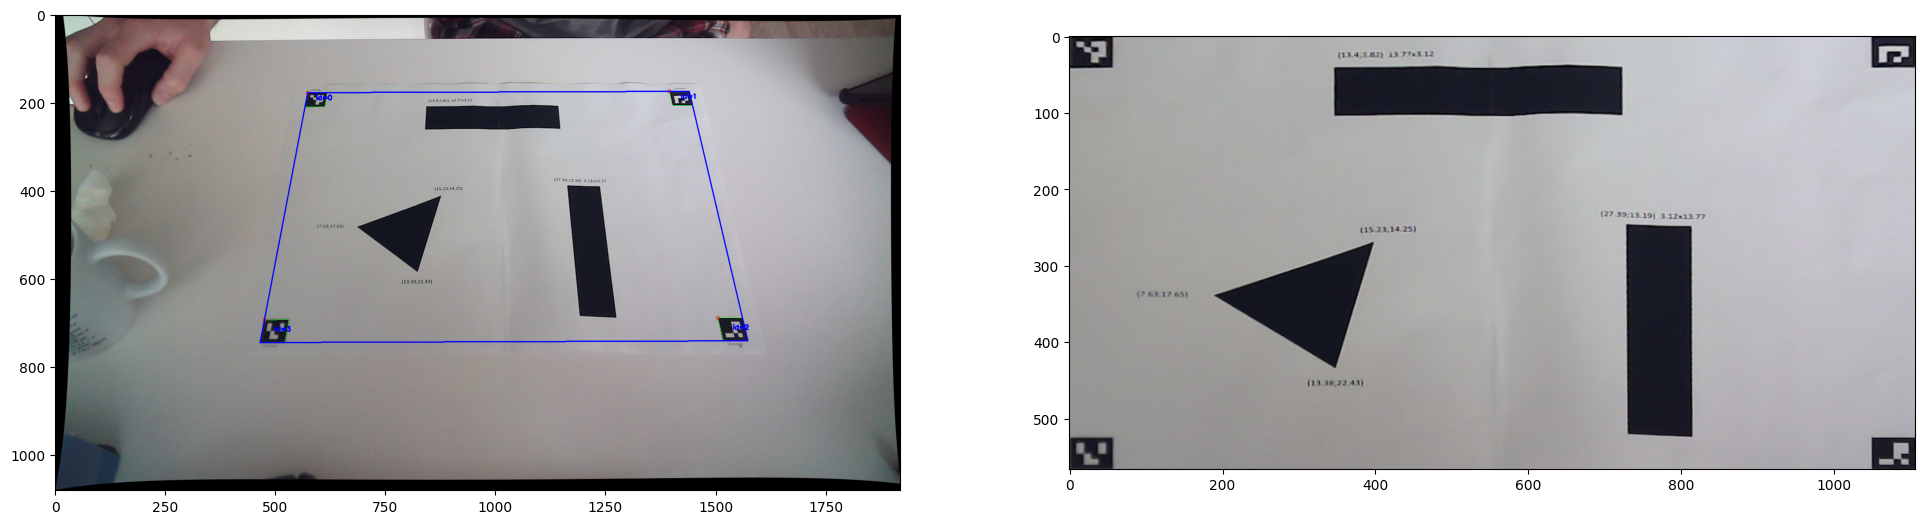

In [333]:
# Draw map limits
img_borders = cv2.imread(MAP_FILE)
#Undistort the image
USE_UNDISTORT = True
if USE_UNDISTORT:
    w,h = img_borders.shape[0:2][::-1]
    mapx, mapy = cv2.initUndistortRectifyMap(cam_mat, dist_coefs, None, new_cam_mat, (w,h), 5)
    img_borders = cv2.remap(img_borders, mapx, mapy, cv2.INTER_LINEAR)
    MARKER_SIZE = 1.15
    detector = cv2.aruco.ArucoDetector(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50))
    img_dectect = cv2.copyTo(img_borders, None)
    corners, ids, rejected = detector.detectMarkers(img_dectect)
    img_detection = cv2.aruco.drawDetectedMarkers(img_dectect, corners, ids)
else:
    img_detection = img_borders
map_img = cv2.copyTo(img_borders, None)
order_id = (3,0,1,2)
corner_num = (3,0,1,2)
roi_points = []
for i in range(len(order_id)):
    corner_index = np.argwhere(ids[:,0] == order_id[i])[0,0]
    next_corner = np.argwhere(ids[:,0] == order_id[(i+1)%len(ids)])[0,0]
    p1 = np.array([corners[corner_index][0][corner_num[i],0], corners[corner_index][0][corner_num[i],1]], dtype=int)
    p2 = np.array([corners[next_corner][0][corner_num[(i+1)%len(corner_num)],0], corners[next_corner][0][corner_num[(i+1)%len(corner_num)],1]], dtype=int)
    roi_points.append(p1)
    cv2.line(img_detection,p1.astype(int), p2.astype(int), [255,0,0], 2)

p_mid_down = (roi_points[3] + roi_points[0])/2
p_mid_up = (roi_points[2] + roi_points[1])/2
roi_map = np.array([roi_points[0][0], roi_points[1][1], roi_points[3][0]-roi_points[0][0], p_mid_down[1] - p_mid_up[1]], dtype=int)
#ret, rvec, tvec = cv2.solvePnP((0,0), roi_points[0], cam_mat, dist_coefs)

fig = plt.figure(figsize=(24,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_detection[:,:,::-1])

print(roi_map)
x,y,w,h = roi_map
m_perspective = cv2.getPerspectiveTransform(np.float32(roi_points), np.float32([[0,h],[0,0],[w,0],[w,h]]))
map_img = cv2.warpPerspective(map_img, m_perspective, (w,h))
#cv2.line(map_img, (0,110), (1100, 110), color=[0,0,255], thickness=2)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(map_img[:,:,::-1])



Edges detection (keeping ROI delimited by markers)

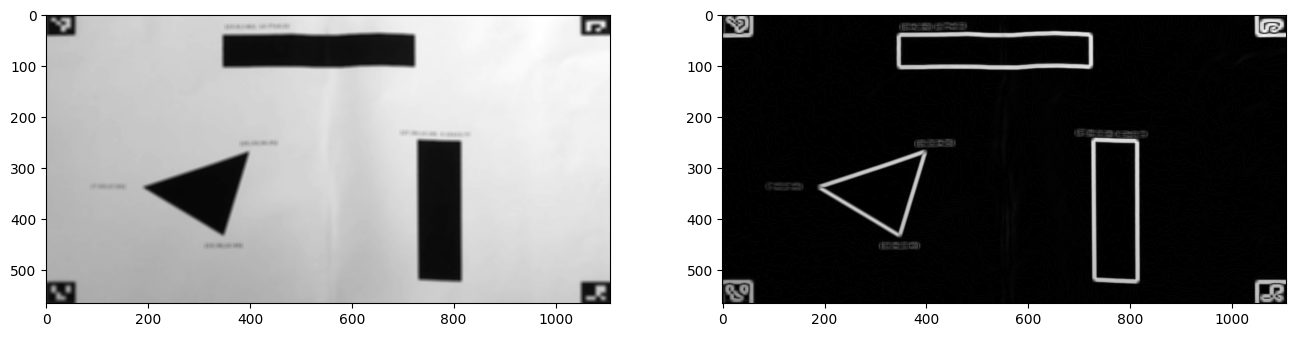

In [364]:
# Using the re-projected map from last step
#img = cv2.imread(MAP_FILE, cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(map_img, cv2.COLOR_BGR2GRAY)
img_filtered = cv2.GaussianBlur(img, (9,9), 6)


fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_filtered, cmap='gray')

sobx = cv2.Sobel(img_filtered, cv2.CV_64F, 1, 0, 3)
soby = cv2.Sobel(img_filtered, cv2.CV_64F, 0, 1, 3)
sob = np.sqrt(sobx**2 + soby**2)
sob = (sob * 255 / sob.max()).astype(np.uint8)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(sob, cmap='gray')




Having all of the edges, compute the grid and fill it accordingly

In [416]:
import matplotlib.ticker as ticker

def configure_ax(ax, max_x, max_y, res):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    MAJOR = 10
    MINOR = 5
    
    major_ticks_x = np.arange(0, max_x+1, MAJOR)
    minor_ticks_x = np.arange(0, max_x+1, MINOR)
    major_ticks_y = np.arange(0, max_y+1, MAJOR)
    minor_ticks_y = np.arange(0, max_y+1, MINOR)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_y])
    ax.set_xlim([-1,max_x])
    ax.set_ylabel('y (cm)')
    ax.set_xlabel('x (cm)')
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/res))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/res))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.grid(True)

    return ax

The grid map is defined as follow:  (195, 130)
Pixels per grid cell: 5.676923076923077 x 4.3538461538461535


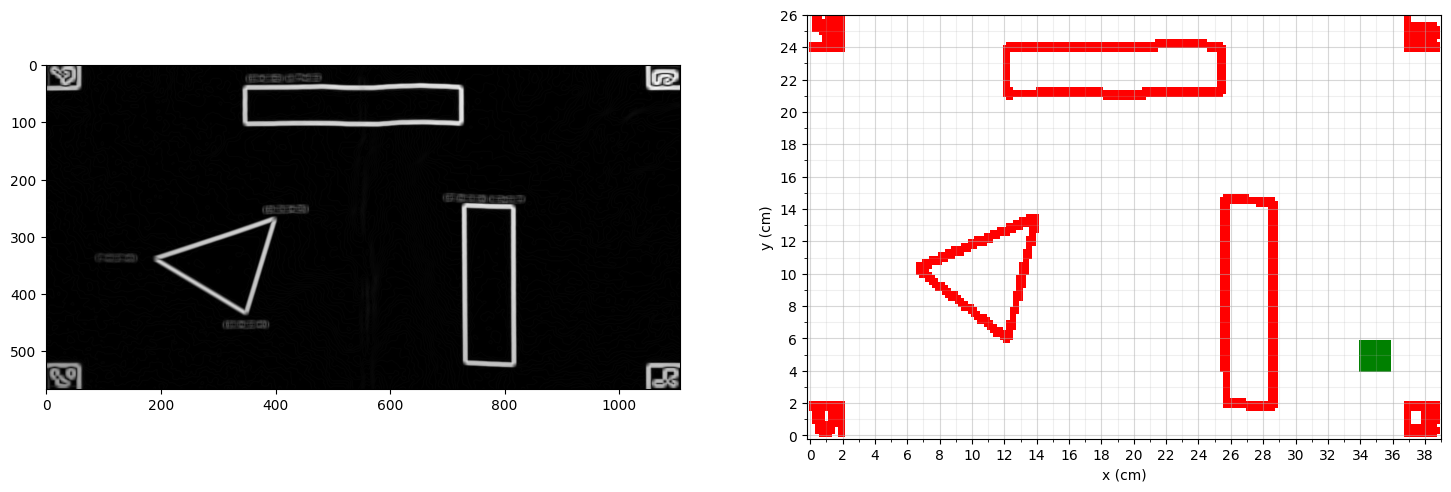

In [417]:
# Real map corners
MAP_W, MAP_H = 39,26  # In centimeters
CORNERS_REAL_POS = np.array([[0,0], [0,MAP_H], [MAP_W, MAP_H], [MAP_W,0]])
RES = 5 # Number of cells per centimeter
THRESHOLD = 100 # 0-255 for pixel intensity

#Initialize the grid
grid_map = np.zeros(((int)(RES*MAP_W), (int)(RES*MAP_H)))
print("The grid map is defined as follow: ", grid_map.shape)

# Find grid shape in pixel space
img_edges = cv2.copyTo(sob, None)
h,w = img_edges.shape
grid_w, grid_h = w/(RES*MAP_W), h/(RES*MAP_H)
print(f'Pixels per grid cell: {grid_w} x {grid_h}')

# Compute obstacles positions (OLD)
#for i in range(len(grid_map)):
#    for j in range(len(grid_map[0])):
#        p_x = math.floor(i*grid_w)
#        p_x_1 = min(math.ceil(i*grid_w + grid_w), w)
#        p_y = math.floor((len(grid_map[0])-1-j)*grid_h)
#        p_y_1 = min(math.ceil((len(grid_map[0])-1-j)*grid_h + grid_h),h)
#        grid_map[i,j] = np.mean(img_edges[p_y:p_y_1,p_x:p_x_1]) > THRESHOLD

# Applying threshold to get binary and measuring average and sum of cells in pixel space
cv2.threshold(img_edges, THRESHOLD, 255, cv2.THRESH_BINARY, img_edges)
for i in range(len(grid_map)):
    for j in range(len(grid_map[0])):
        c_x = math.floor(i*grid_w) + grid_w/2
        c_y = math.floor((len(grid_map[0])-1-j)*grid_h) + grid_h/2
        im_rect = cv2.getRectSubPix(img_edges, ((int) (round(grid_w, 0)),(int) (round(grid_h,0))), (c_x,c_y))
        grid_map[i,j] = -1 if cv2.sumElems(im_rect)[0] > cv2.mean(im_rect)[0] else 0

# Temporary goal pose
GOAL_POSE = (35, 5)  # In cm
goal_pose_grid = np.array([GOAL_POSE[0]*RES, GOAL_POSE[1]*RES], dtype=int)
goal_mask = (RES, RES)
begin_x = max(goal_pose_grid[0] - goal_mask[0], 0)
end_x = min(goal_pose_grid[0] + goal_mask[0], grid_map.shape[0])
begin_y = max(goal_pose_grid[1] - goal_mask[1], 0)
end_y = min(goal_pose_grid[1] + goal_mask[1], grid_map.shape[1])
grid_map[begin_x:end_x, begin_y:end_y] = 1

# Show the grid
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(1,2,2)
ax = configure_ax(ax, grid_map.shape[0], grid_map.shape[1], RES)
cmap = colors.ListedColormap(['red', 'white', 'green'])
ax.imshow(grid_map.transpose(), cmap=cmap, origin='lower')
ax = fig.add_subplot(1,2,1)
ax.imshow(sob, cmap='gray')


Objects/Contour/Shape extraction using moments

(See OpenCV [tutorial](https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html))

In [124]:
img = cv2.imread("images/calibration_test.jpg", cv2.IMREAD_GRAYSCALE)

ret, thres = cv2.threshold(sob, 90, 255, cv2.THRESH_BINARY)
contours, hier = cv2.findContours(thres, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(thres, cmap='gray')



error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


## **Pose estimation of the Thymio**

1. Open camera live feed

In [157]:
cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
cam.set(cv2.CAP_PROP_FRAME_COUNT, 30)
cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'mjpg'))

# Read saved cam parameters
cam_calib = cb.CamCalib(None, (9,6))
cam_mat, dist_coefs, rvecs, tvecs = cam_calib.load_camera_params()

# Other parameters
index = 0

if not cam.isOpened():
    print("Error :: Could not open the camera feed!")

while (True):

    ret, frame = cam.read()

    if not ret:
        print("Error :: Impossible to get image from cam!")
        break

    img_markers = detectMarkersAndPose(frame, cam_mat, dist_coefs)
    cv2.imshow("Robot Tracking", img_markers)

    key = cv2.waitKey(30)
    if key == ord('q'):
        break
    elif key == ord('s'):
        cv2.imwrite(f'images/saved_pict_{index}.jpg', frame)
        index += 1

cam.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

Camera image correction

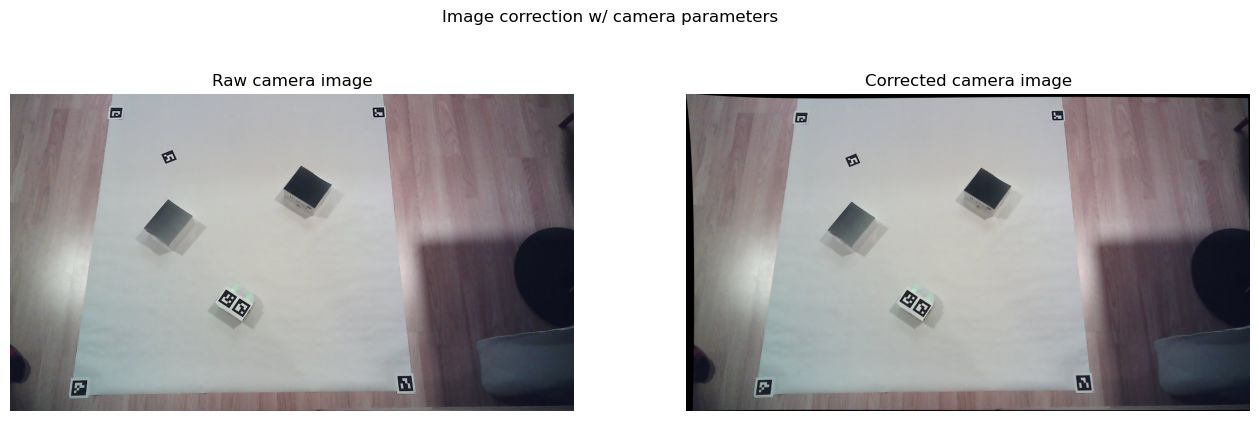

In [22]:
importlib.reload(cb)
cam_calib = cb.CamCalib(None, (9,6))
cam_mat, dist_coefs, rvecs, tvecs = cam_calib.load_camera_params()
thymio = cv2.imread('Vision/images/THYMIO_ENV.jpg', cv2.IMREAD_COLOR)
fig, ax = plt.subplots(1,2)
fig.set_size_inches((16,5))
fig.suptitle('Image correction w/ camera parameters')
ax[0].axis('off')
ax[0].set_title('Raw camera image')
ax[0].imshow(thymio[:,:,::-1])
thymio, roi = cam_calib.undistord(thymio, cam_mat, dist_coefs)
ax[1].axis('off')
ax[1].set_title('Corrected camera image')
ax[1].imshow(thymio[:,:,::-1])


Pixels per grid cell: 8.333333333333334 x 8.333333333333334
Goal detected @:  [27.12 95.22]
GOAL @  [27.12 95.22]


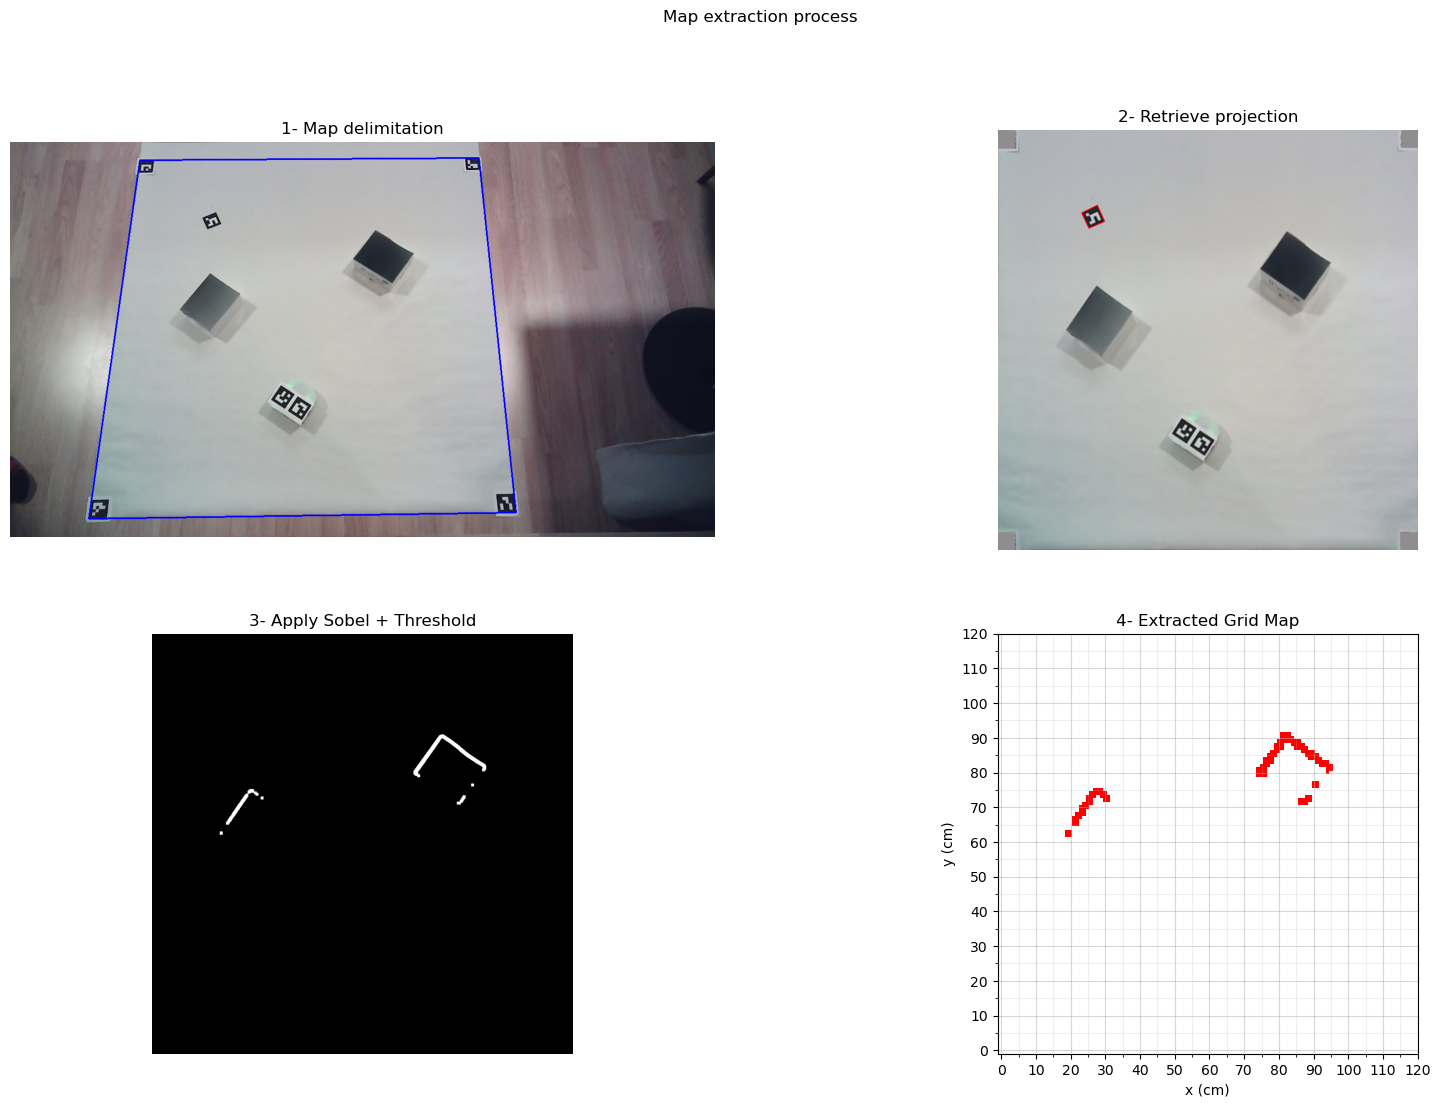

In [23]:
#%matplotlib inline
# For debugging/testing, use saved image
importlib.reload(tracker)
MAP_SIZE = (120,120)
env_tracker = tracker.EnvTracker(MAP_SIZE, cam_mat, dist_coefs)
# Keeping just the roi of the corrected image
x,y,w,h = roi
thymio = thymio[y:y+h,x:x+w,:]
ret, img_markers = env_tracker.detectMarkers(thymio)
map_detected, img_markers = env_tracker.detectMap(thymio)
goal_detected, img_markers = env_tracker.detectGoal(thymio)
grid_map, goal_pose = env_tracker.createMap(thymio)

2. Detect thymio and extract pose & orientation from 2D projected map

Estimated thymio pose:  [89.175 52.23 ]
Estimated angle: 175.94


(-0.5, 999.5, 999.5, -0.5)

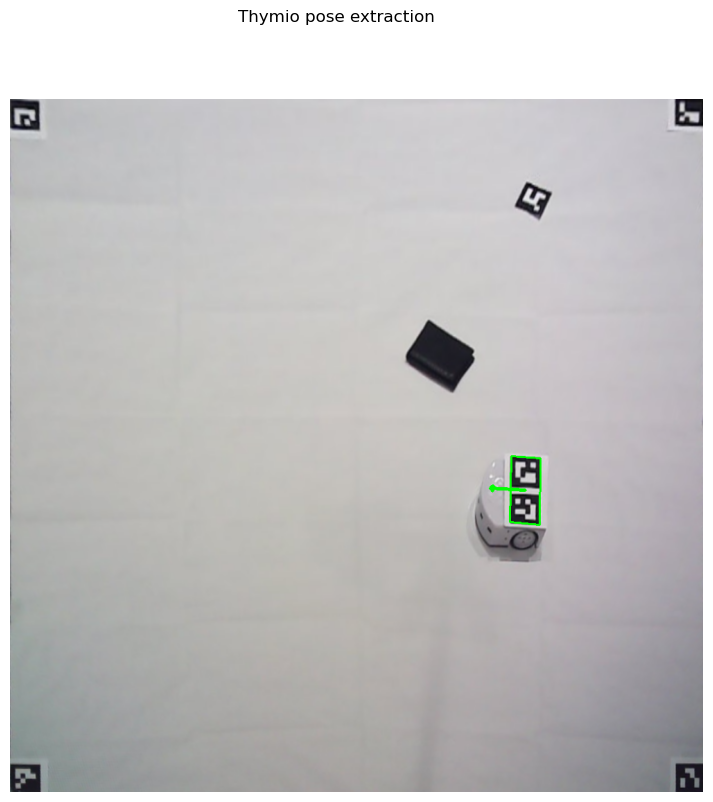

In [19]:
img_markers = env_tracker.getProjectedMap(thymio)
ret, _= env_tracker.detectMarkers(img_markers)
thymio_detected, img_markers = env_tracker.detectThymio(img_markers)
ret, thymio_pose, thymio_angle, img_markers = env_tracker.thymioPose(img_markers)
print("Estimated thymio pose: ", thymio_pose)
print("Estimated angle: %.2f" % (thymio_angle*180/np.pi))
#img_markers = detectMarkersAndPose(thymio, cam_mat, dist_coefs)
fig = plt.figure(figsize=(16,9))
fig.suptitle('Thymio pose extraction')
ax = fig.add_subplot()
ax.imshow(img_markers[:,:,::-1])
ax.axis('off')

(Extra) Detect thymio and extract pose & orientation directly in 3D world

Estimated thymio pose:  [96.35038351 51.96254022]
Estimated angle: 27.76


(-0.5, 1255.5, 703.5, -0.5)

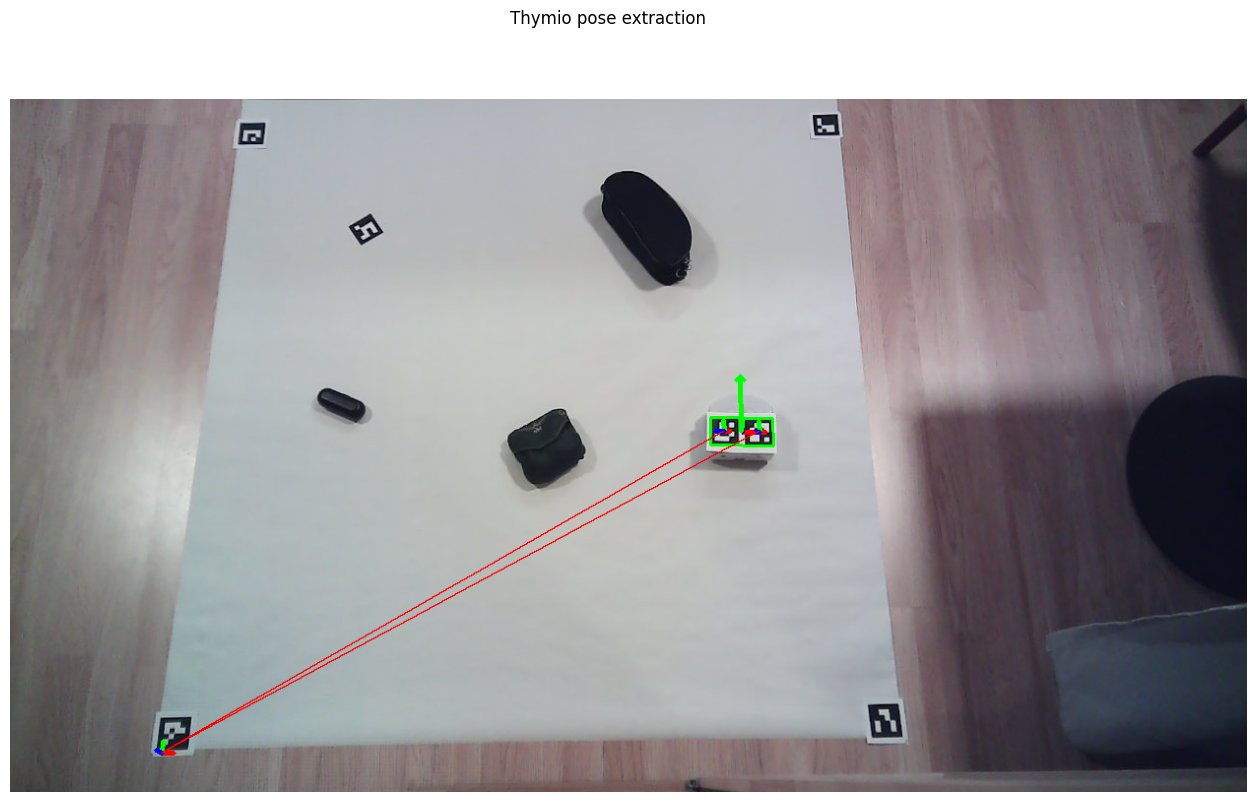

In [21]:
img_markers = env_tracker.extractMapCornerPose(thymio)
thymio_detected, img_markers = env_tracker.detectThymio(img_markers)
ret, thymio_pose, thymio_angle, img_markers = env_tracker.thymioPose(img_markers, show_all=True)
print("Estimated thymio pose: ", thymio_pose)
print("Estimated angle: %.2f" % (thymio_angle*180/np.pi))
#img_markers = detectMarkersAndPose(thymio, cam_mat, dist_coefs)
fig = plt.figure(figsize=(16,9))
fig.suptitle('Thymio pose extraction')
ax = fig.add_subplot()
ax.imshow(img_markers[:,:,::-1])
ax.axis('off')

### Using OpenCV GUI & realtime tracking

Pixels per grid cell: 8.333333333333334 x 8.333333333333334
Goal detected @:  [27.12 95.22]


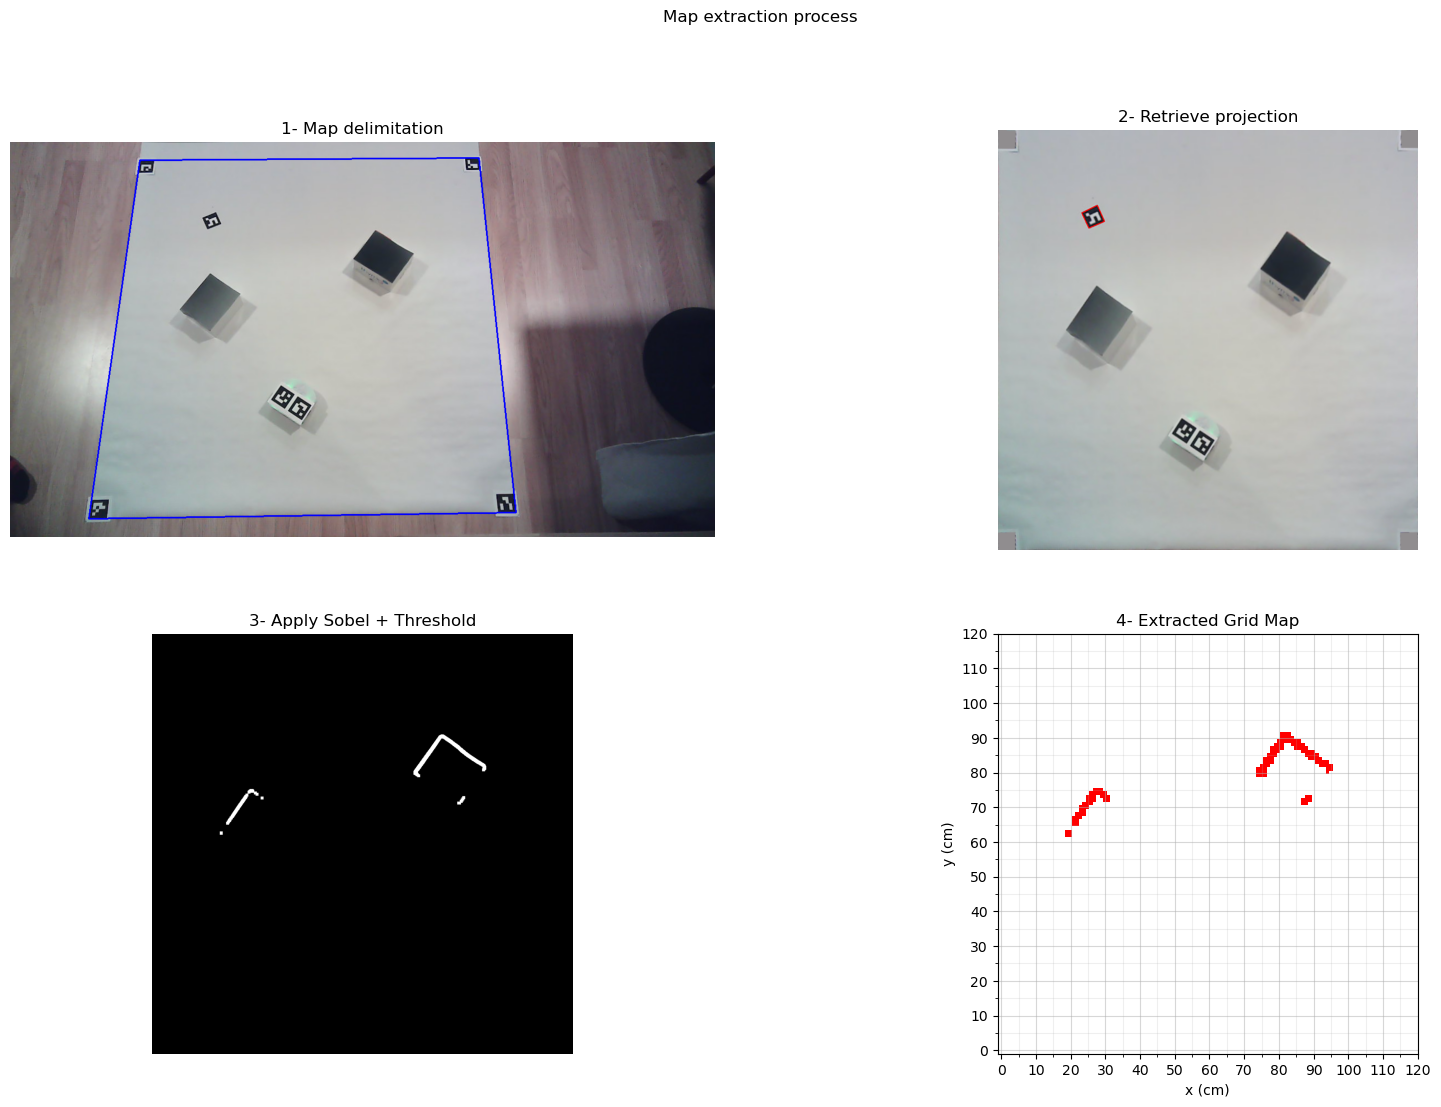

In [20]:
#%matplotlib qt
# Detect map in cam feed
importlib.reload(tracker)
test_img = cv2.imread('Vision/images/TEST_MAP_70x70_2.jpg')
map_created= False
run = True
cam_calib = cb.CamCalib(None, (16,9))
cam_mat, dist_coefs, rvecs, tvecs = cam_calib.load_camera_params()
env_tracker = tracker.EnvTracker((120,120), cam_mat, dist_coefs)
cv2.namedWindow("Live camera feed", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Live camera feed", 1680, 1050)

cam_feed = cv2.VideoCapture(0)
cam_feed.set(cv2.CAP_PROP_FRAME_WIDTH, 1680)
cam_feed.set(cv2.CAP_PROP_FRAME_HEIGHT, 1050)


map_created, grid_map, goal_pose = env_tracker.wait_for_map(cam_feed, cam_calib)
if not map_created:
    print("WARNING :: Map was not created")
run = False
while (run):
    ret, test_img = cam_feed.read()
    test_img, roi = cam_calib.undistord(test_img, cam_mat, dist_coefs)
    x,y,w,h = roi
    test_img = test_img[y:y+h, x:x+w, :]
    ret, img_markers = env_tracker.detectMarkers(test_img)
    map_detected, img_markers = env_tracker.detectMap(img_markers)
    goal_detected, img_markers = env_tracker.detectGoal(img_markers)
    if goal_detected:
        goal_pose, _ = env_tracker.goalPose3D(test_img)
    if map_detected:
        img_markers = env_tracker.extractMapCornerPose(img_markers)
        img_markers = cv2.putText(img_markers, "MAP DETECTED", (img_markers.shape[1] - 300, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, [0,255,0], 2)
        img_markers = cv2.putText(img_markers, "GOAL DETECTED", (img_markers.shape[1] - 300, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, [0,255,0], 2)
    cv2.imshow("Live camera feed",img_markers)
    key = cv2.waitKey(1)
    if key == ord('q'):
        run = False
    elif key == ord(' '):
        # Create map
        cv2.imwrite('Vision/images/THYMIO_ENV.jpg', test_img)
        if map_detected and goal_detected:
            grid_map, goal_pose = env_tracker.createMap(test_img, bl_marker=0)
            # Extract goal pose
            text_goal = f'GOAL: {np.round(goal_pose, 1)}'
            map_created = True
            run = False

#if map_created:
#    run = True
#    v_feed = cv2.VideoCapture('Vision/videos/TEST_RUN_THYMIO_2.mp4')
#    v_feed.set(cv2.CAP_PROP_BUFFERSIZE, 2)
#    fps = v_feed.get(cv2.CAP_PROP_FPS)
#    fps_ms = (int)(math.floor(1/fps * 1000))
#    if not v_feed.isOpened():
#        print("Failed to open video feed!")
#        run = False
# Show video
track_thymio = False
show_markers = False
frame_counter = 0
text_pose = 'POS: ??'
text_angle = 'ANGLE: ??'
text_vel = 'VEL: ??'
text_ang_vel = 'ANG. VEL: ??'
text_goal = f'GOAL: {np.round(goal_pose, 1)}'
pose_hist = np.zeros((2,10))
angle_hist = np.zeros(10)
run = True
cv2.resizeWindow("Live camera feed", 1200, 1000)
while (run):
    success, frame = cam_feed.read()
    if not success:
        run = False
    # Detect map & thymio
    frame_corrected, roi = cam_calib.undistord(frame, cam_mat, dist_coefs)
    x,y,w,h = roi
    frame_corrected = frame_corrected[y:y+h, x:x+w, :]
    if track_thymio:
        success, thymio_pose, thymio_vel, img_thymio = env_tracker.updateThymio(frame_corrected, show_markers)
        img_sidebar = np.zeros((img_thymio.shape[0], 200, 3), dtype=np.uint8)
        if success:
            #thymio_pose = np.round(thymio_pose, 1)
            #pose_hist[:,frame_counter % 10] = thymio_pose
            #thymio_angle = round(thymio_angle*180/math.pi, 0)
            #angle_hist[frame_counter % 10] = thymio_angle
            #if (frame_counter % 10) == 0:
            text_pose = f'POSE: {np.round(thymio_pose[:2], 1)}'
            text_angle = f'ANGLE: {round(thymio_pose[2]*180/math.pi, 0)}'
            text_vel = f'VEL: {np.round(thymio_vel[:2], 1)}'
            text_ang_vel = f'ANG. VEL: {round(thymio_vel[2]*180/math.pi, 1)}'
        cv2.putText(img_sidebar, text_pose, (10, 100), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_angle, (10, 175), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_vel, (10, 250), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_ang_vel, (10, 325), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        cv2.putText(img_sidebar, text_goal, (10, 400), cv2.FONT_HERSHEY_TRIPLEX, 0.5, [0,255,0], 1)
        # Concatenate images
        img_thymio = cv2.hconcat([img_thymio, img_sidebar])
    else:
        img_thymio = env_tracker.getProjectedMap(frame_corrected)
    cv2.imshow("Live camera feed",img_thymio)
    key = cv2.waitKey(1)
    if key == ord('q'):
        run = False
    elif key == ord(' '):
        track_thymio = not track_thymio
    elif key == ord('m'):
        show_markers = True
    frame_counter += 1


if cam_feed:
    cam_feed.release()
cv2.destroyAllWindows()
            

In [55]:
cam_feed.release()
cv2.destroyAllWindows()

### TEST & OLD STUFF

In [246]:
def detectMarkersAndPose(frame, cam_mtx, dist_coeffs, marker_size=3, marker_dist=10) -> cv2.Mat:
    
    detector = cv2.aruco.ArucoDetector(cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50))
    img_detect = cv2.copyTo(frame, None)
    corners, ids, rejected = detector.detectMarkers(img_detect)
    img_detect = cv2.aruco.drawDetectedMarkers(img_detect, corners, ids)
    # Create corner points
    obj_points = cv2.Mat(np.array([[-marker_dist/2, marker_size/2, 0], 
                            [marker_dist/2, marker_size/2, 0], 
                            [marker_dist/2, -marker_size/2, 0], 
                            [-marker_dist/2, -marker_size/2, 0]]))

    rvecs, tvecs = [], []

    THYMIO_MARKER_IDS = (4,5)
    new_thymio_corners = np.zeros((4,2))
    ids = np.reshape(ids, -1)
    thymio_detected = False
    # Check if thymio markers were found in image
    if np.all(np.isin(THYMIO_MARKER_IDS, ids)):
        thymio_detected = True
        indices = np.where(np.isin(ids, THYMIO_MARKER_IDS))[0]
        for i in indices:
            if ids[i] == THYMIO_MARKER_IDS[0]:
                # Found marker 4
                new_thymio_corners[0,:] = corners[i][0][0,:]
                new_thymio_corners[3,:] = corners[i][0][3,:]
            else:
                # Found marker 5
                new_thymio_corners[1,:] = corners[i][0][1,:]
                new_thymio_corners[2,:] = corners[i][0][2,:]

        # Compute transformation vectors & rotation matrix
        ret, rvec_thymio, tvec_thymio = cv2.solvePnP(obj_points, new_thymio_corners, cam_mtx, dist_coefs)
        img_detect = cv2.drawFrameAxes(img_detect, cam_mtx, dist_coefs, rvec_thymio, tvec_thymio, 2, 4)

        # Draw the heading of the thymio (big arrow pointing forward)
        v_thymio = np.array([[0,0,0], [0,10,0]], dtype=float)
        v_pixels, _ = cv2.projectPoints(v_thymio, rvec_thymio, tvec_thymio, cam_mtx, dist_coeffs)
        cv2.arrowedLine(img_detect, v_pixels[0][0].astype(int), v_pixels[1][0].astype(int), [0,255,0], 3)

    # Check if map is detected and compute origin pose
    MAP_MARKER_IDS = (0,1,2,3)
    MAP_WIDTH, MAP_HEIGHT = (42+2*5,30)
    MAP_MARKER_SIZE = 5 # in cm
    new_map_corners = np.zeros((4,2))
    thymio_pose_estimation = np.zeros((4,3))
    # Check if thymio markers were found in image
    if np.all(np.isin(MAP_MARKER_IDS, ids)):
        indices = np.where(np.isin(ids, MAP_MARKER_IDS))[0]
        # Create map object points
        obj_map = cv2.Mat(np.array([[0,0,0],
                                    [0,MAP_MARKER_SIZE,0],
                                    [MAP_MARKER_SIZE,MAP_MARKER_SIZE,0],
                                    [MAP_MARKER_SIZE,0,0]], dtype=float))
        for m_index, c_index in zip([MAP_MARKER_IDS.index(ids[i]) for i in indices], indices):
            new_map_corners[m_index, :] = corners[c_index][0][0,:]
            # Compute transformation vectors & rotation vectors
            ret, rvec, tvec = cv2.solvePnP(obj_map, corners[c_index], cam_mtx, dist_coefs)
            img_detect = cv2.drawFrameAxes(img_detect, cam_mtx, dist_coefs, rvec, tvec, 2, 4)
            # Compute distance to thymio
            if thymio_detected:
                R = cv2.Rodrigues(rvec)[0]
                P = np.hstack((R, tvec))
                # Homogeneous matrix & point
                P = np.vstack((P, np.array([0,0,0,1])))
                p = np.vstack((tvec_thymio.reshape((3,1)), [1]))
                thymio_pose_estimation[m_index,:] = np.linalg.solve(P,p)[0:3].T
                # Draw lines
                v_map = np.array([[0,0,0]], dtype=float)
                v_pixels, _ = cv2.projectPoints(v_map, rvec_thymio, tvec_thymio, cam_mtx, dist_coeffs)
                v_pixels2, _ = cv2.projectPoints(v_map, rvec, tvec, cam_mtx, dist_coeffs)
                cv2.line(img_detect, v_pixels2[0][0].astype(int), v_pixels[0][0].astype(int), [0,0,255], 1, cv2.LINE_4)

        # Compute best estimate (average) of thymio pose
        # HARD CODED STUFF HERE, MAYBE NOT THE BEST...
        thymio_pose_estimation[1,:2] = np.array([thymio_pose_estimation[1,1], MAP_HEIGHT - thymio_pose_estimation[1,0]])
        thymio_pose_estimation[2,:2] = np.array([MAP_WIDTH,MAP_HEIGHT]) - thymio_pose_estimation[2,:2]
        thymio_pose_estimation[3,:2] = np.array([MAP_WIDTH - thymio_pose_estimation[3,1], thymio_pose_estimation[3,0]])
        thymio_pose = np.mean(thymio_pose_estimation, 0)
        print(thymio_pose)
        
        # Add a green rectangle to show detection
        for i in range(4):
            cv2.line(img_detect, new_map_corners[i,:].astype(int), new_map_corners[(i+1)%4,:].astype(int), [0,255,0], 2)


        # Compute transformation vectors & rotation vectors
        #ret, rvec, tvec = cv2.solvePnP(obj_map, new_map_corners, cam_mtx, dist_coefs)
        #rvecs.append(rvec)
        #tvecs.append(tvec)
        #img_detect = cv2.drawFrameAxes(img_detect, cam_mtx, dist_coefs, rvec, tvec, 2, 4)

        # Quick test before bed =D
        #v_map = np.array([[0,0,0]], dtype=float)
        #v_pixels, _ = cv2.projectPoints(v_map, rvec_thymio, tvec_thymio, cam_mtx, dist_coeffs)
        #v_pixels2, _ = cv2.projectPoints(v_map, rvecs[0], tvecs[0], cam_mtx, dist_coeffs)
        #cv2.line(img_detect, v_pixels2[0][0].astype(int), v_pixels[0][0].astype(int), [255,0,0], 2)

        # Get Rotation matrix (Rodrigues)
        #r_mat = cv2.Rodrigues(rvecs[0])[0]
        #P = np.hstack((R, tvecs[0]))
        #P = np.vstack((P, np.array([0,0,0,1])))
        #p = np.vstack((tvec_thymio.reshape((3,1)), [1]))
        #thymio_pos = np.linalg.solve(P,p)
        #print(thymio_pos[:3])

    return img_detect

In [60]:
# NUMPY ARRAYS TESTS
test_ids = (0,1,2,3)
test = np.array([-5,-4,2,1,3,0])
THYMIO_MARKER_SIZE = 2
THYMIO_MARKER_DIST = 10
test_obj = cv2.Mat(np.array([[-THYMIO_MARKER_SIZE/2, THYMIO_MARKER_SIZE/2, 0], 
                            [THYMIO_MARKER_SIZE/2, THYMIO_MARKER_SIZE/2, 0], 
                            [THYMIO_MARKER_SIZE/2, -THYMIO_MARKER_SIZE/2, 0], 
                            [-THYMIO_MARKER_SIZE/2, -THYMIO_MARKER_SIZE/2, 0]]))
test_obj2 = test_obj.copy()
test_obj2[:,0:2] = test_obj[:,0:2] + np.array([THYMIO_MARKER_DIST, THYMIO_MARKER_DIST])
test_obj2 = cv2.Mat(np.concatenate((test_obj[:], test_obj2[:])))
print(test_obj2)

print(np.all(np.isin(test_ids, test)))
print(np.where(np.isin(test, test_ids)))

print(test % 2)

test3 = np.array([20,15], dtype='uint8')
print(test3 / np.array([2,5]))



# Get Rotation matrix (Rodrigues)
#r_mat = cv2.Rodrigues(rvecs[0])
# Desired vector in "Thymio/Marker" space
#v_thymio = np.array([0,1,0])
# Convert to image/pixel space
#print(tvecs[0])
#T = np.hstack((r_mat, tvecs[0][:,0].reshape((3,1))))
#T = np.vstack((T, np.array([0,0,0,1])))
#v_pixels = np.linalg.solve(T, np.vstack((v_thymio, np.array([1]))))
#print(cv2.convertPointsFromHomogeneous(v_pixels))

[[-1.  1.  0.]
 [ 1.  1.  0.]
 [ 1. -1.  0.]
 [-1. -1.  0.]
 [ 9. 11.  0.]
 [11. 11.  0.]
 [11.  9.  0.]
 [ 9.  9.  0.]]
True
(array([2, 3, 4, 5], dtype=int64),)
[1 0 0 1 1 0]
[20 15]
[10.  3.]
